In [1]:
#%pip install openpyxl wordcloud flair hdbscan==0.8.40 bertopic spacy numpy==1.26.4

In [2]:
import pandas as pd
import configparser

from wordcloud import WordCloud

In [3]:
config = configparser.ConfigParser(interpolation=None)
config.read('config.ini')

url = config['MS_AZURE']['URL']
sas_token = config['MS_AZURE']['SAS_TOKEN']

In [4]:
import os
import platform

def is_running_on_azure():
    return "AML_CloudName" in os.environ

In [5]:
import requests

if is_running_on_azure() is True:
    url = url+"Macroprestazioni_infermieristiche.xlsx?" + sas_token

    response = requests.get(url)
    if response.status_code == 200:
        with open("Macroprestazioni_infermieristiche.xlsx", "wb") as f:
            f.write(response.content)
        print("Download completato.")
        df_prestazioni_inf = pd.read_excel("Macroprestazioni_infermieristiche.xlsx")
    else:
        print(f"Errore: {response.status_code}")
else:
    df_prestazioni_inf = pd.read_excel("dataset/Macroprestazioni_infermieristiche.xlsx")

Download completato.


/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [6]:
df_prestazioni_inf.columns

Index(['Macroprestazione', 'Note infermieristiche',
       'Prestazione da nomenclatore'],
      dtype='object')

In [7]:
df_prestazioni_inf.rename(columns={"Macroprestazione": "macroprestazione", "Note infermieristiche": "testo", "Prestazione da nomenclatore": "cod_valoremedio_liquidazione"}, inplace=True)

In [8]:
df_prestazioni_inf.head(10)

,macroprestazione,testo,cod_valoremedio_liquidazione
0,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievi ematici,033t
1,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievi venosi,033t
2,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievi,033t
3,Medicazioni Avanzate,Medicazioni varie,031t
4,procedure clinico assistenziali,Clistere /svuotamento manuale,080t
5,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievi ematici,033t
6,Medicazioni Avanzate,Medicazioni,031t
7,Medicazioni Avanzate,Medicazioni,031t
8,Educazione Sanitaria,Educazione al caregiver,122r
9,Medicazioni Avanzate,Medicazioni,031t


In [9]:
print("Numero di prestazioni sanitarie: " + str(len(df_prestazioni_inf)))

Numero di prestazioni sanitarie: 39490


In [10]:
df_prestazioni_inf.dropna(inplace=True)
df_prestazioni_inf.reset_index(inplace=True)
print("Numero di prestazioni sanitarie dopo cleaning di righe vuote: " + str(len(df_prestazioni_inf)))

Numero di prestazioni sanitarie dopo cleaning di righe vuote: 22614


### Analisi esplorativa

In [14]:
df_prestazioni_inf.groupby('cod_valoremedio_liquidazione').count()[['testo']].rename(columns={'testo': 'count'}).sort_values(by='count', ascending=False).to_csv("csv/N_prestazioni_by_cod_valoremedio_liquidazione.csv", sep=';')

In [18]:
df_prestazioni_inf.groupby('macroprestazione').count()[['testo']].rename(columns={'testo': 'count'}).sort_values(by='count', ascending=False).to_csv("csv/N_prestazioni_by_macroprestazione.csv", sep=';')

In [19]:
df_prestazioni_inf.groupby('testo').count()[['macroprestazione']].rename(columns={'macroprestazione': 'count'}).sort_values(by='count', ascending=False).to_csv("csv/N_prestazioni_by_note_infermieristiche.csv", sep=';')

### Cleaning dei testi

In [11]:
import re
import spacy
from spacy.cli.download import download

download('it_core_news_lg') # italian

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.9/567.9 MB 48.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [12]:
it_nlp = spacy.load("it_core_news_lg")
stop_words = list(it_nlp.Defaults.stop_words)

In [15]:
def apply_text_cleaning(text):
    
    # 2. Normalize curly quotes and dashes
    text = text.replace("’", "'").replace("‘", "'") \
               .replace("“", '"').replace("”", '"') \
               .replace("–", "-").replace("—", "-")

    # Optional: normalize Unicode characters to ASCII (e.g., é → e)
    # text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")    

    # 4. Lowercase
    text = text.lower()

    # 5. Remove punctuation (keep straight apostrophes and dashes)
    text = re.sub(r"[^\w\s]", '', text)

    # 6. Remove digits
    text = re.sub(r'\d+', '', text)

    return text
    # 7. Tokenize and remove stopwords: le rimuovo durante l'applicazione di BERTopic
   # sentences = italian_tokenizer.tokenize(text)
   # tokens = [word for sent in sentences for word in sent.split()]
   # tokens = [word for word in tokens if word not in stop_words]

   #return ' '.join(tokens)

In [16]:
df_prestazioni_inf['testo_pulito'] = [apply_text_cleaning(x) for x in df_prestazioni_inf["testo"]]

In [17]:
df_prestazioni_inf['cod_valoremedio_liquidazione'] = [x.upper() for x in df_prestazioni_inf['cod_valoremedio_liquidazione']]

In [18]:
df_prestazioni_inf.iloc[200:280]

,index,macroprestazione,testo,cod_valoremedio_liquidazione,testo_pulito
200,204,Monitoraggi e Misurazioni,Monitoraggio parametri clinici,004T,monitoraggio parametri clinici
201,205,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievo,033T,prelievo
202,206,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievi,033T,prelievi
203,207,Monitoraggi e Misurazioni,Monitoraggio parametri vitali,004T,monitoraggio parametri vitali
204,208,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievo,033T,prelievo
...,...,...,...,...,...
275,284,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievi ematici,033T,prelievi ematici
276,285,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievi ematici,033T,prelievi ematici
277,286,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievo ematico/INR,033T,prelievo ematicoinr
278,287,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievi ematici,033T,prelievi ematici


Link descrizione testuale del "cod_valoremedio_liquidazione"

In [19]:
df_codes_valmedio_liq = pd.read_csv("classifications/Classificazione_da_decreto_valoremedioliquidazione.csv", sep='\t')

In [20]:
df_codes_valmedio_liq.rename(columns={'Codice':'cod_valoremedio_liquidazione'},inplace=True)

In [21]:
df_prestazioni_inf.columns

Index(['index', 'macroprestazione', 'testo', 'cod_valoremedio_liquidazione',
       'testo_pulito'],
      dtype='object')

In [22]:
df_prestazioni_inf = df_prestazioni_inf[['index','macroprestazione','testo','testo_pulito','cod_valoremedio_liquidazione']]

In [23]:
df_merge = df_prestazioni_inf.merge(df_codes_valmedio_liq, how='left', on='cod_valoremedio_liquidazione')


In [24]:
len(df_prestazioni_inf)

22614

In [25]:
len(df_merge)

22614

In [26]:
nan_rows = df_merge.isnull().any(axis=0)
print(nan_rows)

index                           False
macroprestazione                False
testo                           False
testo_pulito                    False
cod_valoremedio_liquidazione    False
ELENCO PRESTAZIONI               True
dtype: bool


In [27]:
df_merge.rename(columns={'ELENCO PRESTAZIONI': 'descr_cod_valoremedio_liquidazione'},inplace=True)
df_merge.columns

Index(['index', 'macroprestazione', 'testo', 'testo_pulito',
       'cod_valoremedio_liquidazione', 'descr_cod_valoremedio_liquidazione'],
      dtype='object')

In [28]:
df_merge.head(10)

,index,macroprestazione,testo,testo_pulito,cod_valoremedio_liquidazione,descr_cod_valoremedio_liquidazione
0,0,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievi ematici,prelievi ematici,033T,Prelievo capillare e venoso del sangue o racco...
1,1,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievi venosi,prelievi venosi,033T,Prelievo capillare e venoso del sangue o racco...
2,2,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievi,prelievi,033T,Prelievo capillare e venoso del sangue o racco...
3,3,Medicazioni Avanzate,Medicazioni varie,medicazioni varie,031T,Medicazione semplice
4,4,procedure clinico assistenziali,Clistere /svuotamento manuale,clistere svuotamento manuale,080T,Preparazione ed effettuazione di clistere
5,5,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Prelievi ematici,prelievi ematici,033T,Prelievo capillare e venoso del sangue o racco...
6,6,Medicazioni Avanzate,Medicazioni,medicazioni,031T,Medicazione semplice
7,7,Medicazioni Avanzate,Medicazioni,medicazioni,031T,Medicazione semplice
8,8,Educazione Sanitaria,Educazione al caregiver,educazione al caregiver,122R,Accoglienza del paziente: presentazione di luo...
9,9,Medicazioni Avanzate,Medicazioni,medicazioni,031T,Medicazione semplice


In [29]:
df_merge[df_merge['descr_cod_valoremedio_liquidazione'].isnull()]#.to_csv("df_prestazioni_inf_con_descrizione_codvaloremedio_liquidazione_null.csv",sep='\t',index=False)

,index,macroprestazione,testo,testo_pulito,cod_valoremedio_liquidazione,descr_cod_valoremedio_liquidazione
1284,1459,Educazione Sanitaria,"colloquio famigliare, singole, educativi, info...",colloquio famigliare singole educativi informa...,122T,NaN
2275,2504,Educazione Sanitaria,Colloquio infermieristico,colloquio infermieristico,122T,NaN
2296,2525,Educazione Sanitaria,colloquio confamiliari,colloquio confamiliari,122T,NaN
2394,2627,"PAI, pianificazione, valutazione",Interventi di supporto,interventi di supporto,122T,NaN
2620,2877,"PAI, pianificazione, valutazione",analisi dei bisogni,analisi dei bisogni,122T,NaN
...,...,...,...,...,...,...
22158,38498,procedure clinico assistenziali,Mobilizzazione e igiene,mobilizzazione e igiene,105R,NaN
22173,38522,procedure clinico assistenziali,igiene e mobilizzazione,igiene e mobilizzazione,105R,NaN
22269,38708,"Accesso Vascolare, Terapia Infusiva, Prelievo ...",Gestione dispositivi vascolari,gestione dispositivi vascolari,077R,NaN
22540,39322,procedure clinico assistenziali,Assistenza di base/cura della persona,assistenza di basecura della persona,105R,NaN


In [30]:
df_prestazioni_inf.to_csv("csv/df_prestazioni_inf_clean.csv",sep='\t',index=False)

### Wordcloud dei testi

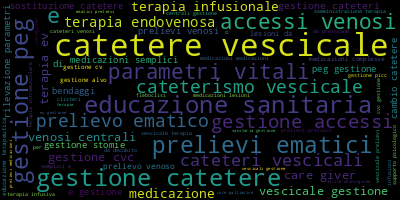

In [31]:
full_text = ','.join(list(df_prestazioni_inf["testo_pulito"].values))
wordcloud = WordCloud(background_color="black",
                        max_words=100,
                        contour_width=2,
                        contour_color='yellow')

wordcloud.generate(full_text)
wordcloud.to_image()

### Topic analysis

In [32]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pickle
from transformers.pipelines import pipeline
from hdbscan import HDBSCAN
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
from flair.embeddings import TransformerDocumentEmbeddings

roberta = TransformerDocumentEmbeddings('xlm-roberta-base') # max lunghezza di un testo a cui associare un topic è di 512 caratteri

In [25]:
hdbscan_model = HDBSCAN(min_cluster_size = 100, metric = 'euclidean',
                        cluster_selection_method = 'eom', prediction_data=True, min_samples = 50)
                        
umap_model = UMAP(n_neighbors=15, n_components = 5,
                  min_dist=0.1, metric='cosine', random_state=42)

#vectorizer_model = CountVectorizer(tokenizer=custom_tokenizer, lowercase=True, ngram_range=(1, 1), min_df=0.05, max_df = 0.99, stop_words=stop_words, analyzer='word')
vectorizer_model = CountVectorizer(lowercase=True, ngram_range=(1, 2), min_df=0.05, max_df = 0.99, stop_words=stop_words,analyzer='word')


topic_model = BERTopic(language="italian", embedding_model = roberta,
                 calculate_probabilities = True, low_memory = True, verbose = True,
                 min_topic_size = 100, top_n_words = 20, vectorizer_model = vectorizer_model, hdbscan_model=hdbscan_model,umap_model=umap_model)

In [34]:
all_texts = list(df_prestazioni_inf["testo_pulito"])

In [27]:
topics, probs = topic_model.fit_transform(all_texts)

2025-05-15 15:41:32,931 - BERTopic - Embedding - Transforming documents to embeddings.
100%|██████████| 22614/22614 [13:53<00:00, 27.13it/s]
2025-05-15 15:55:26,556 - BERTopic - Embedding - Completed ✓
2025-05-15 15:55:26,557 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-15 15:56:18,114 - BERTopic - Dimensionality - Completed ✓
2025-05-15 15:56:18,115 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-15 15:56:25,677 - BERTopic - Cluster - Completed ✓
2025-05-15 15:56:25,699 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-15 15:56:25,861 - BERTopic - Representation - Completed ✓


In [28]:
freq = topic_model.get_topic_info()
freq_count_sum = freq['Count'].sum()
freq['Perc'] = freq['Count']/freq_count_sum
freq

,Topic,Count,Name,Representation,Representative_Docs,Perc
0,-1,6463,-1_clisteri_infusioni_terapia_terapie,"[clisteri, infusioni, terapia, terapie, gestio...","[educazione care giver, educazione al care giv...",0.285796
1,0,2056,0_somministrazione_paziente_somministrazione t...,"[somministrazione, paziente, somministrazione ...","[somministrazione terapia, somministrazione te...",0.090917
2,1,738,1_prelievi_prelivi_controlli_vitali,"[prelievi, prelivi, controlli, vitali, ev, , ,...","[prelievi, prelievi, prelievi]",0.032635
3,2,656,2_medicazioni medicazioni_medicazioni_educazio...,"[medicazioni medicazioni, medicazioni, educazi...","[medicazioni, medicazioni, medicazioni]",0.029009
4,3,536,3_prelievi ematici_ematici_prelievi_ematici urine,"[prelievi ematici, ematici, prelievi, ematici ...","[prelievi ematici, prelievi ematici, prelievi ...",0.023702
...,...,...,...,...,...,...
57,56,104,56_parametri vitali_vitali_parametri_controlli,"[parametri vitali, vitali, parametri, controll...","[parametri vitali, parametri vitali, parametri...",0.004599
58,57,103,57_decubito_lesioni decubito_lesioni_trattamento,"[decubito, lesioni decubito, lesioni, trattame...","[prevenzione e tratamento lesioni da decubito,...",0.004555
59,58,102,58_cambio catetere_cambio_catetere_cambio cate...,"[cambio catetere, cambio, catetere, cambio cat...","[cambio catetere, cambio catetere, cambio cate...",0.004510
60,59,102,59_gestione picc_picc_porth_port,"[gestione picc, picc, porth, port, port gestio...","[gestione picc e port, gestione picc port, ges...",0.004510


In [29]:
freq.to_csv("csv/berttopic_frequencies_61_topic_15052025.csv", sep = ';')

In [30]:
topic_model.save("bert_models/berttopic_fnopi_61_topic_15052025", serialization="safetensors", save_ctfidf=True, save_embedding_model=roberta)

In [35]:
topic_model = BERTopic.load("bert_models/berttopic_fnopi_61_topic_15052025", embedding_model = roberta)

In [31]:
import plotly.io as pio
pio.renderers.default = 'iframe'  # Try 'notebook' or 'iframe' if needed 'azure','jupyterlab'

In [37]:
# Extract hierarchical topics and their representations
hierarchical_topics = topic_model.hierarchical_topics(all_texts)

100%|██████████| 60/60 [00:00<00:00, 314.94it/s]


In [43]:
hierarchical_topics.reset_index()

,index,Parent_ID,Parent_Name,Topics,Child_Left_ID,Child_Left_Name,Child_Right_ID,Child_Right_Name,Distance
0,59,120,prelievi_gestione_catetere_vescicale_catetere ...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",116,vescicale_catetere vescicale_catetere_peg gest...,119,prelievi_prelievo_medicazioni_medicazioni medi...,1.597996
1,58,119,prelievi_prelievo_medicazioni_medicazioni medi...,"[0, 1, 2, 3, 4, 5, 8, 9, 10, 12, 13, 14, 15, 1...",117,prelievi_prelievo_prelievi ematici_ematici_ema...,118,medicazioni_medicazioni medicazioni_educazione...,1.550312
2,57,118,medicazioni_medicazioni medicazioni_educazione...,"[0, 2, 4, 5, 9, 10, 12, 13, 15, 16, 17, 18, 19...",115,medicazioni_medicazioni medicazioni_educazione...,101,parametri vitali_vitali_parametri_monitoraggio...,1.485449
3,56,117,prelievi_prelievo_prelievi ematici_ematici_ema...,"[1, 3, 8, 14, 20, 23, 24, 28, 32, 44, 60]",114,prelievi_prelievo_prelievi ematici_ematici_ema...,71,accessi venosi_gestione accessi_accessi_venosi...,1.472250
4,55,116,vescicale_catetere vescicale_catetere_peg gest...,"[6, 7, 11, 29, 33, 35, 39, 42, 48, 53, 55, 58]",113,vescicale_catetere vescicale_catetere_vescical...,77,peg gestione_gestione peg_peg_sng_gestione,1.432107
5,54,115,medicazioni_medicazioni medicazioni_educazione...,"[0, 2, 4, 5, 9, 10, 12, 13, 15, 16, 18, 19, 21...",111,educazione_terapia_educazione sanitaria_sanita...,112,medicazioni_medicazioni medicazioni_complesse_...,1.376800
6,53,114,prelievi_prelievo_prelievi ematici_ematici_ema...,"[1, 3, 8, 14, 20, 23, 24, 28]",86,prelievi_prelievi ematici_ematici_prelievi ven...,103,prelievo_ematico_prelievo ematico_venoso_preli...,1.356675
7,52,113,vescicale_catetere vescicale_catetere_vescical...,"[7, 11, 29, 33, 35, 39, 48, 55, 58]",62,cateteri vescicali_vescicali_vescicali gestion...,109,vescicale_catetere vescicale_catetere_vescical...,1.335002
8,51,112,medicazioni_medicazioni medicazioni_complesse_...,"[2, 10, 12, 13, 18, 21, 22, 25, 26, 30, 31, 34...",82,complesse medicazioni_complesse_medicazioni se...,110,medicazioni medicazioni_medicazioni_gestione c...,1.330092
9,50,111,educazione_terapia_educazione sanitaria_sanita...,"[0, 4, 5, 9, 15, 16, 19, 41, 46, 50, 51]",100,sanitaria educazione_educazione sanitaria_sani...,99,terapia_endovenosa_infusionale_terapia infusio...,1.302129


In [44]:
hierarchical_topics.to_csv("csv/hierarchical_topics_61_15052025.csv",sep=';', index=False)

In [35]:
fig= topic_model.visualize_hierarchy()
fig.write_html('html/Bert_topics_visualization_hierarchy_fnopi_61_topic.html')

In [36]:
fig = topic_model.visualize_topics()
fig.write_html('html/Bert_topics_visualization_fnopi_61_topic.html')

### Leggere i topic

In [36]:
rep_docs = topic_model.get_representative_docs()
for topic_id, docs in rep_docs.items():
    print(f"Topic {topic_id}: {docs[0][:200]}")  # Primo documento rappresentativo

In [37]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

In [38]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000, colormap='ocean') # ocean for BERTopic and copper for LDA
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.gca().set_title('Topic ' + str(topic+2), fontdict=dict(size=20))
    #plt.show()
    plt.savefig('img/BERTopic_FNOPI_'+str(topic+2))

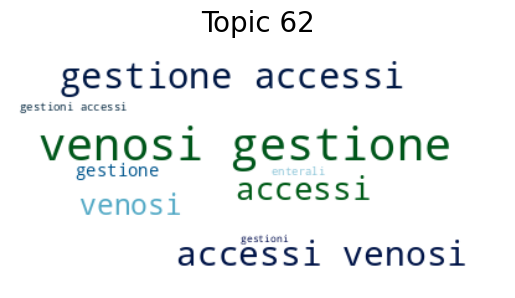

In [39]:
for i in range(-1,61,1):
  create_wordcloud(topic_model, topic=i)